## Lets use the model for inference

A CLIP model was fine-tuned on the Flicker Dataset using spanish translations from the original captions (This is probably a waste of time but it could be useful whenever we needed to use caption texts to a different language like spanish, portuguese, etc)

In [6]:
#!pip install faiss-cpu

In [7]:
import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader,random_split,Subset
import numpy as np
import clip
from tqdm import tqdm
import faiss

In [8]:
#preprocess is just a sequential module
model, preprocess = clip.load("ViT-B/32")

100%|███████████████████████████████████████| 338M/338M [00:21<00:00, 16.7MiB/s]


## Load trained Model

In [9]:
model.load_state_dict(torch.load("checkpoints/best_model.pt"))

<All keys matched successfully>

In [10]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"
#model.to(DEVICE)

## Load Images & Create Dataloaders

In [11]:
BASE_PATH="flicker_data/flickr30k_images/flickr30k_images"
images=datasets.ImageFolder(BASE_PATH,transform=preprocess)

## Preprocess Image and Compute Embeddings

In [12]:
## For testing purposes lets use the first 1000 images
#images_data,_=random_split(images,[1000,len(images)-1000])
images_dataloader=DataLoader(images,batch_size=50)

In [13]:
img_embeddings=[]
model.eval()
for batch,_ in tqdm(images_dataloader):
    with torch.no_grad():
        emb=model.encode_image(batch.to(DEVICE))
    img_embeddings.extend(emb)
img_embeddings=torch.vstack(img_embeddings).detach().cpu().numpy()

100%|██████████| 636/636 [1:03:19<00:00,  5.97s/it]


In [14]:
img_embeddings.shape

(31783, 512)

In [22]:
#CHECKPOINT
with open('embeddings.npy', 'wb') as f:
    np.save(f, img_embeddings)

In [16]:
##LOAD
img_embeddings = np.load('embeddings.npy')

## Index Embeddings using Faiss

In [17]:
def preprocess_embeddings(embeddings: np.ndarray):
    embeddings = embeddings.astype("float32")
    if len(embeddings.shape) == 1:
        embeddings = embeddings.reshape(1, -1)
    faiss.normalize_L2(embeddings)
    return embeddings

emb=preprocess_embeddings(img_embeddings)

In [18]:
faiss_index = faiss.IndexFlatIP(emb.shape[1])
faiss_index = faiss.IndexIDMap(faiss_index)
faiss_index.train(emb)
faiss_index.add_with_ids(emb,np.arange(len(images)))

## Create Visualization Modules

In [19]:
def search_images(text,k=10):
    text_emb=model.encode_text(clip.tokenize(text,truncate=True).to(DEVICE)).detach().cpu().numpy()
    text_emb=preprocess_embeddings(text_emb)
    faiss_cos_sim, k_nearest_indexes = faiss_index.search(text_emb, k=k)
    return faiss_cos_sim,k_nearest_indexes

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as vision
from torchvision.transforms import ToPILImage,Resize,ToTensor
%matplotlib inline

process_inference=vision.Compose([
        Resize((224,224),interpolation=vision.InterpolationMode.BICUBIC),
        ToTensor()
        ])

def get_images(text,top_k=10):
    sim,idx=search_images(text,top_k)
    img_names=[process_inference(Image.open(images.imgs[i][0])) for i in idx.squeeze().tolist()]
    grid=make_grid(img_names, nrow=5)
    img = ToPILImage()(grid)
    f,ax=plt.subplots(figsize=(15,12))
    ax.imshow(img)
    print(f"Avg Similarity : {np.mean(sim):.2%}")
    plt.title(f" Similar images to '{text}'\n",size=14)


Avg Similarity : 33.42%


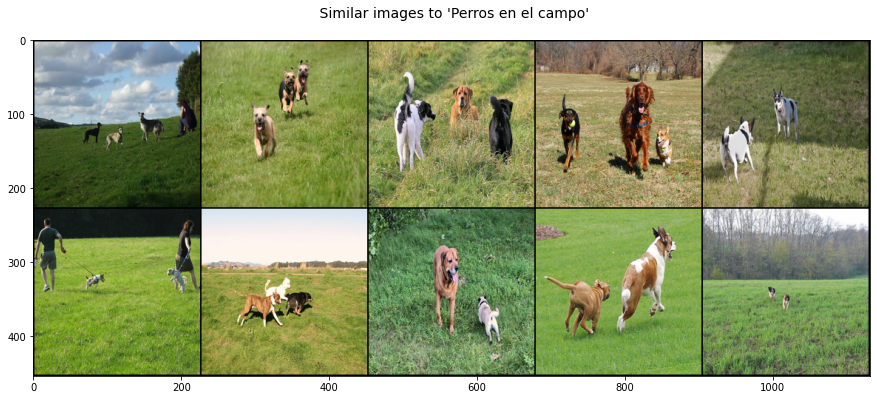

In [21]:
input_str="Perros en el campo"
get_images(input_str)

Avg Similarity : 31.12%


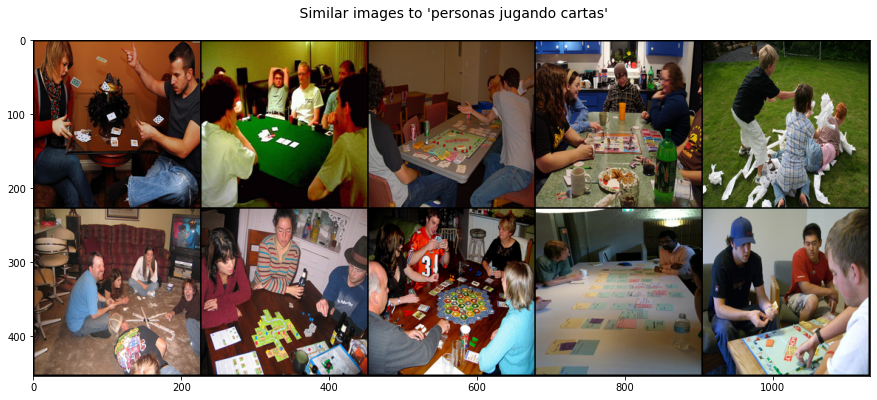

In [25]:
input_str="personas jugando cartas"
get_images(input_str)